In [1]:
import os
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.datasets import OxfordIIITPet, Flowers102

import matplotlib.pyplot as plt
import numpy as np
import scipy

import copy
import re

## Load Dataset

In [2]:
class NeuralNetwork():
    def __init__(self, basemodel, output, train_loader, val_loader, test_loader, unfreeze=0, parameters=None):
        # Init model
        self.model = copy.deepcopy(basemodel)
        # changing the fully connected layer
        self.model.fc = nn.Linear(self.model.fc.in_features, output)
        # Unfreeze the L last layers and fully connected last layer
        self.unfreeze_layers(unfreeze)
        self.model = self.model.to(device)

        self.optimizer = optim.Adam([{"params": self.model.fc.parameters(),"lr": 1e-3, "weight_decay": 1e-4},])
        self.criterion = nn.CrossEntropyLoss()

        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader

        self.parameters = parameters if parameters is not None else {}


    def unfreeze_layers(self, L):
      # freezing all layers
      for p in self.model.parameters():
          p.requires_grad = False

      layer = 0
      # unfreeze last L layers and fully connected layer
      for name, p in reversed(list(self.model.named_parameters())):
        if layer < L+1:
          if not name.endswith("bias"):
            layer += 1
          p.requires_grad = True

    def check_trainable_layers(self):
        for name, param in self.model.named_parameters():
            if param.requires_grad:
                print(f"{name} requires grad")
            else:
                print(f"{name} does NOT require grad")


    def run_epoch(self, loader, train=True):
        self.model.train() if train else self.model.eval()
        total_loss, correct, total = 0.0, 0, 0
        cx = "cutmix" in self.parameters and self.parameters["cutmix"]

        for imgs, labs in loader:
            imgs, labs = imgs.to(device), labs.to(device)
            if train:
                self.optimizer.zero_grad()
                if cx:
                  imgs, labs, shuff_labs, lam = cutmix(imgs, labs, self.parameters['alpha'])

            logits = self.model(imgs)
            loss   = self.criterion(logits, labs)

            if train:
              if cx:
                loss = lam * loss + (1 - lam) * self.criterion(logits, shuff_labs)
              loss.backward()
              self.optimizer.step()

            total_loss += loss.item() * imgs.size(0)
            preds      = logits.argmax(dim=1)
            correct   += (preds == labs).sum().item()
            total     += imgs.size(0)

        return total_loss/total, correct/total*100


    def test_model(self, test_loader=None):
      if test_loader != None:
        loader = test_loader
      else:
        loader = self.test_loader

      test_loss, test_acc = self.run_epoch(loader, train=False)
      print(f"Test Accuracy: {test_acc:.2f}%")
      return test_acc

    def train(self, epochs, path="model.pth"):
      best_val_acc = 0.0
      for epoch in range(1,epochs+1):

        # gradually unfreeze layers for strategy 2 according to rate parameter
        if 'gradual_unfreezing' in self.parameters:
            uf_rate = 1 if not 'unfreezing_rate' in self.parameters else parameters['unfreezing_rate']
            L = np.floor(uf_rate*(1+epoch)) # allow for rates < 1
            if L < 1:
                L = 1
            self.unfreeze_layers(L)

        tr_loss, tr_acc = self.run_epoch(self.train_loader, train=True)
        val_loss, val_acc = self.run_epoch(self.val_loader, train=False)
        print(f"Epoch {epoch:2d} | Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(self.model.state_dict(), path)

      test_acc = self.test_model()
      return test_acc

    def train2(self, epochs, path="model.pth"):
        best_val_acc = 0.0
        for epoch in range(1, epochs+1):
            # Gradual unfreezing
            if self.parameters.get('gradual_unfreezing', False):
                uf_rate = self.parameters.get('unfreezing_rate', 1)
                L = int(np.floor(uf_rate * (epoch + 1)))
                if L < 1:
                    L = 1
                self.unfreeze_layers(L)

            tr_loss, tr_acc = self.run_epoch(self.train_loader, train=True)
            val_loss, val_acc = self.run_epoch(self.val_loader, train=False)
            print(f"Epoch {epoch:2d} | Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

            # Save best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), path)

            # Step scheduler if present
            if hasattr(self, 'scheduler') and self.scheduler is not None:
                self.scheduler.step()

        return self.test_model()

    def train_catastrophic(self, epochs, path="model.pth", tee = True, test_loader=None): # tee=test_eac_epoch
        best_val_acc = 0.0
        results = {"primary": [], "secondary":[]}
        for epoch in range(1, epochs+1):
            # Gradual unfreezing
            if self.parameters.get('gradual_unfreezing', False):
                uf_rate = self.parameters.get('unfreezing_rate', 1)
                L = int(np.floor(uf_rate * (epoch + 1)))
                if L < 1:
                    L = 1
                self.unfreeze_layers(L)

            tr_loss, tr_acc = self.run_epoch(self.train_loader, train=True)
            val_loss, val_acc = self.run_epoch(self.val_loader, train=False)
            print(f"Epoch {epoch:2d} | Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")

            # Save best
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                torch.save(self.model.state_dict(), path)

            if tee:
                results["primary"].append(self.test_model())
                if test_loader != None:
                    results["secondary"].append(self.test_model(test_loader = test_loader))
            # Step scheduler if present
            if hasattr(self, 'scheduler') and self.scheduler is not None:
                self.scheduler.step()
        if not tee:
            return self.test_model()

        return results

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0

        # Track per-class accuracy
        class_correct = [0] * len(breed_names)
        class_total = [0] * len(breed_names)

        with torch.no_grad():
            for inputs, targets in self.test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                outputs = self.model(inputs)
                _, predicted = outputs.max(1)

                # Overall accuracy
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                # Per-class accuracy
                for i in range(len(targets)):
                    label = targets[i].item()
                    class_total[label] += 1
                    if predicted[i] == targets[i]:
                        class_correct[label] += 1

        overall_acc = 100.0 * correct / total
        per_class_acc = [(100.0 * class_correct[i] / class_total[i] if class_total[i] > 0 else 0.0)
                          for i in range(len(breed_names))]

        return overall_acc, per_class_acc, class_total


In [3]:
OxfordIIITPet(root="data", download=True)

100%|██████████| 792M/792M [00:37<00:00, 21.3MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.6MB/s]


Dataset OxfordIIITPet
    Number of datapoints: 3680
    Root location: data

In [4]:
annnotations_dir = os.path.join("data", "oxford-iiit-pet", "annotations")
lines_for_files = open(os.path.join(annnotations_dir, "list.txt")).read().splitlines()[6:]
species_map = {l.split()[0]: int(l.split()[2]) for l in lines_for_files}

In [5]:
with open(os.path.join(annnotations_dir, "trainval.txt")) as f:
    trainval_names = [l.split()[0] for l in f if l.strip()]
with open(os.path.join(annnotations_dir, "test.txt")) as f:
    test_names = [l.split()[0] for l in f if l.strip()]

In [6]:
class BinaryPet(Dataset):
    def __init__(self, root, names, species_map, transform=None):
        self.root = root
        self.names = names
        self.species_map = species_map
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = os.path.join(
            self.root, "oxford-iiit-pet", "images", name + ".jpg"
        )
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = self.species_map[name] - 1  # 1→cat→0, 2→dog→1
        return img, label

In [7]:
IMG_SIZE = 224

In [8]:
transformIMG = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

In [9]:
full = BinaryPet("data", trainval_names, species_map, transform=transformIMG)
n_val = int(0.1 * len(full))
train_ds, val_ds = random_split(full, [len(full)-n_val, n_val])

In [10]:
test_ds = BinaryPet("data", test_names, species_map, transform=transformIMG)

In [11]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# Binary Classification

## Model Set Up

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
# freezing all
for p in model.parameters():
    p.requires_grad = False
# changing the fully connected layer
model.fc = nn.Linear(model.fc.in_features, 2)
# Unfreeze the fully connected last layer
for name, p in model.named_parameters():
    if name.startswith("fc"):
        p.requires_grad = True
model = model.to(device)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 133MB/s]


In [ ]:
criterion = nn.CrossEntropyLoss()

In [ ]:
optimizer = optim.Adam([
    {"params": model.fc.parameters(),     "lr": 1e-3, "weight_decay": 1e-4},
])

In [ ]:
print(torch.cuda.is_available())

True


## Training

In [ ]:
def run_epoch(model, loader, train=True, criterion=criterion, optimizer=optimizer): # TODO: Include criterion and optimizer in a neater way
    model.train() if train else model.eval()
    total_loss, correct, total = 0.0, 0, 0
    for imgs, labs in loader:
        imgs, labs = imgs.to(device), labs.to(device)
        if train:
            optimizer.zero_grad()
        logits = model(imgs)
        loss   = criterion(logits, labs)
        if train:
            loss.backward()
            optimizer.step()
        total_loss += loss.item() * imgs.size(0)
        preds      = logits.argmax(dim=1)
        correct   += (preds == labs).sum().item()
        total     += imgs.size(0)
    return total_loss/total, correct/total*100


In [ ]:
best_val_acc = 0.0
for epoch in range(1, 25):
    tr_loss, tr_acc = run_epoch(model, train_loader, train=True)
    val_loss, val_acc = run_epoch(model, val_loader, train=False)
    print(f"Epoch {epoch:2d} | Train: {tr_acc:.2f}% | Val: {val_acc:.2f}%")
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), "best_binary_resnet34.pth")

KeyboardInterrupt: 

In [ ]:
model.load_state_dict(torch.load("best_binary_resnet34.pth"))
test_loss, test_acc = run_epoch(model, test_loader, train=False)
print(f"Test Accuracy: {test_acc:.2f}%")

# Multi Class Classification

## Load Dataset

In [15]:
annnotations_dir = os.path.join("data", "oxford-iiit-pet", "annotations")
lines_for_files = open(os.path.join(annnotations_dir, "list.txt")).read().splitlines()[6:]
breeds_map = {l.split()[0]:re.split(r'_\d+', l.split()[0])[0] for l in lines_for_files}

In [16]:
breed_to_id = {val: i for i, val in enumerate(sorted(set(breeds_map.values())))}
id_to_breed = {v: k for k, v in breed_to_id.items()}

In [17]:
class MultiClassPet(Dataset):
    def __init__(self, root, names, breeds_map, transform=None):
        self.root = root
        self.names = names
        self.breeds_map = breeds_map
        self.transform = transform
        self.apply_tf = True

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        name = self.names[idx]
        img_path = os.path.join(
            self.root, "oxford-iiit-pet", "images", name + ".jpg"
        )
        img = Image.open(img_path).convert("RGB")
        if self.transform and self.apply_tf:
            img = self.transform(img)
        label = breed_to_id[self.breeds_map[name]]
        return img, label

In [18]:
full = MultiClassPet("data", trainval_names, breeds_map, transform=transformIMG)
n_val = int(0.1 * len(full))
train_ds, val_ds = random_split(full, [len(full)-n_val, n_val])
test_ds = MultiClassPet("data", test_names, breeds_map, transform=transformIMG)


In [19]:
batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

## Model Set Up

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
basemodel = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 170MB/s]


-> Strategy 1

In [ ]:
# Strategy 1: train with l layers unfrozen simultaneously
accs = []
for L in range(1, 10):
  print(f"Start training model with {L} last layers trainable")
  modelmulti = NeuralNetwork(basemodel, 37, train_loader, val_loader, test_loader, unfreeze=L)
  accs.append(modelmulti.train(10))

Start training model with 1 last layers trainable


KeyboardInterrupt: 

In [ ]:


# Transforms
base_tf = transforms.Compose([
    transforms.Resize(256), transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
aug_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])

# Create datasets and split 90/10
full_ds = MultiClassPet("data", trainval_names, breeds_map, transform=base_tf)
n_val   = int(0.1 * len(full_ds))
train_ds, val_ds = random_split(full_ds, [len(full_ds)-n_val, n_val])
test_ds = MultiClassPet("data", test_names, breeds_map, transform=base_tf)

# DataLoaders
batch_size = 32
val_loader  = DataLoader(val_ds,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Strategy 1 grid
results = []
basemodel = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

for use_aug in [False, True]:
    for freeze_bn in [False, True]:
        for use_l2 in [False, True]:
            for use_sched in [False, True]:
                print(f"\n>>> aug={use_aug}, freeze_bn={freeze_bn}, L2={use_l2}, sched={use_sched}")

                # a) Set train transform
                train_ds.dataset.transform = aug_tf if use_aug else base_tf

                # b) Train loader
                train_loader = DataLoader(
                    train_ds, batch_size=batch_size, shuffle=True,
                    num_workers=4, pin_memory=True
                )

                # c) Init model, fine-tune last 6 layers
                model = NeuralNetwork(
                    basemodel=basemodel,
                    output=len(breed_names),
                    train_loader=train_loader,
                    val_loader=val_loader,
                    test_loader=test_loader,
                    unfreeze=6,
                    parameters={}
                )
                model.model.to(device)

                # d) Freeze batch-norm if requested
                if freeze_bn:
                    for m in model.model.modules():
                        if isinstance(m, nn.BatchNorm2d):
                            m.eval()
                            for p in m.parameters():
                                p.requires_grad = False

                # e) Optimizer with two LR groups, optional L2 weight decay
                wd = 1e-2 if use_l2 else 0.0
                head_p = list(model.model.fc.parameters())
                back_p = [p for n,p in model.model.named_parameters()
                          if p.requires_grad and not n.startswith("fc")]
                model.optimizer = optim.AdamW([
                    {"params": head_p, "lr":1e-3, "weight_decay":wd},
                    {"params": back_p, "lr":1e-4, "weight_decay":wd}
                ])

                # f) Scheduler if requested
                if use_sched:
                    model.scheduler = optim.lr_scheduler.StepLR(model.optimizer, step_size=5, gamma=0.1)
                else:
                    model.scheduler = None

                # g) Train and record test accuracy
                acc = model.train(epochs=10)
                results.append(((use_aug, freeze_bn, use_l2, use_sched), acc))

# Summary for comparison
print("\n=== Strategy 1 Extended Grid Results ===")
for (aug, bn, l2, sched), acc in results:
    print(f"aug={aug}, freeze_bn={bn}, L2={l2}, sched={sched} → Test Acc: {acc:.2f}%")



>>> aug=False, freeze_bn=False, L2=False, sched=False
Epoch  1 | Train: 74.61% | Val: 86.14%
Epoch  2 | Train: 94.11% | Val: 89.95%
Epoch  3 | Train: 97.49% | Val: 89.40%
Epoch  4 | Train: 99.49% | Val: 89.67%
Epoch  5 | Train: 99.61% | Val: 89.95%
Epoch  6 | Train: 99.64% | Val: 90.49%
Epoch  7 | Train: 99.88% | Val: 90.22%
Epoch  8 | Train: 99.94% | Val: 89.95%
Epoch  9 | Train: 99.82% | Val: 89.13%
Epoch 10 | Train: 99.91% | Val: 89.40%
Test Accuracy: 89.62%

>>> aug=False, freeze_bn=False, L2=False, sched=True
Epoch  1 | Train: 75.91% | Val: 88.86%
Epoch  2 | Train: 94.75% | Val: 88.59%
Epoch  3 | Train: 97.83% | Val: 88.32%
Epoch  4 | Train: 99.12% | Val: 89.67%
Epoch  5 | Train: 99.55% | Val: 89.67%
Epoch  6 | Train: 99.85% | Val: 90.22%
Epoch  7 | Train: 99.91% | Val: 89.40%
Epoch  8 | Train: 99.97% | Val: 89.95%
Epoch  9 | Train: 99.97% | Val: 89.95%
Epoch 10 | Train: 99.97% | Val: 90.22%
Test Accuracy: 90.87%

>>> aug=False, freeze_bn=False, L2=True, sched=False
Epoch  1 | Tr

-> Strategy 2

In [ ]:
# Strategy 2: train with gradual unfreezing
parameters = {}
parameters['gradual_unfreezing'] = True
accs = []

# test rates in steps of two
for rate in [0.3, 0.5, 0.8, 1, 2, 3]:
  print(f"Start training model with uf_rate {rate}")
  parameters['unfreezing_rate'] = rate
  modelmulti = NeuralNetwork(basemodel, 37, train_loader, val_loader, test_loader, unfreeze=1, parameters=parameters)   # start with only one unfrozen layer
  accs.append(modelmulti.train(10))

Start training model with uf_rate 0.3
Epoch  1 | Train: 61.08% | Val: 83.97%
Epoch  2 | Train: 88.68% | Val: 89.13%
Epoch  3 | Train: 91.46% | Val: 90.76%
Epoch  4 | Train: 92.39% | Val: 90.22%
Epoch  5 | Train: 93.75% | Val: 91.30%
Epoch  6 | Train: 94.93% | Val: 90.22%
Epoch  7 | Train: 95.77% | Val: 91.03%
Epoch  8 | Train: 95.92% | Val: 90.22%
Epoch  9 | Train: 96.71% | Val: 89.95%
Epoch 10 | Train: 97.04% | Val: 90.22%
Test Accuracy: 90.27%
Start training model with uf_rate 0.5
Epoch  1 | Train: 60.60% | Val: 83.15%
Epoch  2 | Train: 88.07% | Val: 87.23%
Epoch  3 | Train: 91.70% | Val: 89.67%
Epoch  4 | Train: 93.48% | Val: 89.95%
Epoch  5 | Train: 93.72% | Val: 90.49%
Epoch  6 | Train: 94.96% | Val: 89.95%
Epoch  7 | Train: 95.59% | Val: 90.49%
Epoch  8 | Train: 95.59% | Val: 89.40%
Epoch  9 | Train: 95.98% | Val: 89.13%
Epoch 10 | Train: 96.68% | Val: 89.40%
Test Accuracy: 89.07%
Start training model with uf_rate 0.8
Epoch  1 | Train: 59.48% | Val: 85.60%
Epoch  2 | Train: 88.77

In [ ]:
# Find best regularization values

# transforms
base_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])
auga = [ transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(k,1.0)),
    #transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
]) for k in [0.5, 0.6, 0.8 ]]

augb = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    #transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
])

augc = [ transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    #transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(k),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],
                         [0.229,0.224,0.225]),
]) for k in [10, 15, 25, 40]]

# model
basemodel = models.resnet34(weights=models.ResNet34_Weights.DEFAULT)

# fixed unfreeze rate
fixed_rate = 2.0

# grid definitions
augmentations = [True]
freeze_bns    = [False]
use_l2s       = [False]
schedulers    = ['none']
augies = [base_tf]
augies += auga
augies += [augb]
augies = augc


results = []

# running the grid
for use_aug in augmentations:
    for freeze_bn in freeze_bns:
        for use_l2 in use_l2s:
            for sched in schedulers:
              for aug in augies:
                  # update train transform
                  train_ds.dataset.transform = aug if use_aug else base_tf
                  train_loader = DataLoader(
                      train_ds,
                      batch_size=32,
                      shuffle=True,
                      num_workers=4,
                      pin_memory=True
                  )
                  print(f"\n>>> aug={use_aug}, freeze_bn={freeze_bn}, L2={use_l2}, sched={sched}")

                  # a) Instantiate with gradual unfreezing
                  params = {'gradual_unfreezing': True, 'unfreezing_rate': fixed_rate}
                  model = NeuralNetwork(
                      basemodel,
                      37,
                      train_loader,
                      val_loader,
                      test_loader,
                      unfreeze=1,
                      parameters=params
                  )
                  model.model.to(device)

                  # b) Optionally freeze BatchNorm layers
                  if freeze_bn:
                      for m in model.model.modules():
                          if isinstance(m, nn.BatchNorm2d):
                              m.eval()
                              for p in m.parameters():
                                  p.requires_grad = False

                  # c) Build optimizer (head @1e-3, backbone @1e-4), optional L2
                  wd = 1e-2 if use_l2 else 0.0
                  head_p = list(model.model.fc.parameters())
                  back_p = [
                      p for n,p in model.model.named_parameters()
                      if p.requires_grad and not n.startswith("fc")
                  ]
                  model.optimizer = optim.AdamW([
                      {'params': head_p, 'lr':1e-3, 'weight_decay':wd},
                      {'params': back_p, 'lr':1e-4, 'weight_decay':wd},
                  ])

                  # d) Attach scheduler if desired
                  if sched == 'steplr':
                      model.scheduler = optim.lr_scheduler.StepLR(
                          model.optimizer,
                          step_size=5,
                          gamma=0.1
                      )
                  elif sched == 'onecycle':
                      total_steps = len(train_loader) * 10
                      model.scheduler = optim.lr_scheduler.OneCycleLR(
                          model.optimizer,
                          max_lr=[1e-3,1e-4],
                          total_steps=total_steps,
                          pct_start=0.3,
                          anneal_strategy='cos'
                      )
                  else:
                      model.scheduler = None

                  # e) Train & record
                  acc = model.train2(epochs=15)
                  results.append((use_aug, freeze_bn, use_l2, sched, acc))

# Summary for comparison
print("\n=== Strategy 2 Grid Search Results ===")
print("aug | freeze_bn | L2   | scheduler | TestAcc")
print("----|-----------|------|-----------|--------")
for aug, fb, l2, sch, acc in results:
    print(f"{str(aug):<3} | {str(fb):<9} | {str(l2):<4} | {sch:<9} | {acc:6.2f}%")



>>> aug=True, freeze_bn=False, L2=False, sched=none


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  1 | Train: 58.21% | Val: 86.14%
Epoch  2 | Train: 86.71% | Val: 88.04%
Epoch  3 | Train: 89.61% | Val: 89.40%
Epoch  4 | Train: 91.12% | Val: 88.04%
Epoch  5 | Train: 92.36% | Val: 88.86%
Epoch  6 | Train: 93.09% | Val: 89.40%
Epoch  7 | Train: 93.33% | Val: 87.50%
Epoch  8 | Train: 94.05% | Val: 88.86%
Epoch  9 | Train: 94.84% | Val: 89.13%
Epoch 10 | Train: 94.47% | Val: 89.67%
Epoch 11 | Train: 94.78% | Val: 87.77%
Epoch 12 | Train: 95.59% | Val: 87.50%
Epoch 13 | Train: 95.80% | Val: 88.59%
Epoch 14 | Train: 95.83% | Val: 88.59%
Epoch 15 | Train: 95.98% | Val: 87.50%
Test Accuracy: 88.28%

>>> aug=True, freeze_bn=False, L2=False, sched=none
Epoch  1 | Train: 58.09% | Val: 83.42%
Epoch  2 | Train: 85.60% | Val: 83.97%
Epoch  3 | Train: 88.71% | Val: 85.05%
Epoch  4 | Train: 89.89% | Val: 89.40%
Epoch  5 | Train: 91.73% | Val: 87.23%
Epoch  6 | Train: 91.52% | Val: 88.86%
Epoch  7 | Train: 92.57% | Val: 88.59%
Epoch  8 | Train: 93.72% | Val: 88.59%
Epoch  9 | Train: 94.41% | V

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 16

Epoch  3 | Train: 86.65% | Val: 84.51%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>
self._shutdown_workers()Traceback (most recent call last):

  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
        Exception ignored in: self._shutdown_workers()if w.is_alive():
<function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers

  Traceback (most recent call last):
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    s

Epoch  4 | Train: 87.29% | Val: 82.07%


Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
   Exception ignored in:  <function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540> 
 Traceback (most recent call last):
   File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^    ^self._shutdown_workers()^
^^^^^  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
^    if w.is_alive():^Exception ignored in: ^<function _MultiProcessingDataLoaderIter.__del__ at 0x7f11645c4540>

Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader

Epoch  5 | Train: 88.47% | Val: 86.14%
Epoch  6 | Train: 88.38% | Val: 83.70%
Epoch  7 | Train: 89.07% | Val: 85.05%
Epoch  8 | Train: 90.52% | Val: 85.87%
Epoch  9 | Train: 90.55% | Val: 85.33%
Epoch 10 | Train: 91.12% | Val: 85.05%
Epoch 11 | Train: 91.27% | Val: 85.05%
Epoch 12 | Train: 92.12% | Val: 85.87%
Epoch 13 | Train: 91.30% | Val: 84.78%
Epoch 14 | Train: 91.79% | Val: 84.51%
Epoch 15 | Train: 92.57% | Val: 86.96%
Test Accuracy: 88.03%

>>> aug=True, freeze_bn=False, L2=False, sched=none
Epoch  1 | Train: 60.14% | Val: 85.60%
Epoch  2 | Train: 88.07% | Val: 88.59%
Epoch  3 | Train: 91.21% | Val: 89.40%
Epoch  4 | Train: 92.57% | Val: 88.86%
Epoch  5 | Train: 93.42% | Val: 89.13%
Epoch  6 | Train: 93.57% | Val: 89.95%
Epoch  7 | Train: 95.02% | Val: 91.03%
Epoch  8 | Train: 96.14% | Val: 88.32%
Epoch  9 | Train: 95.86% | Val: 90.76%
Epoch 10 | Train: 96.53% | Val: 90.49%
Epoch 11 | Train: 96.35% | Val: 89.95%
Epoch 12 | Train: 96.35% | Val: 89.40%
Epoch 13 | Train: 97.07% | V

## Imbalanced classes

1. Load the annotations/trainval.txt file

In [ ]:
# 0) Prepare names and label maps
names = []
breeds_map = {}

with open("data/oxford-iiit-pet/annotations/trainval.txt", "r") as f:
    for line in f:
        parts = line.strip().split()
        name = parts[0]
        class_id = int(parts[1]) - 1  # 0-indexed
        names.append(name)
        breeds_map[name] = class_id

breed_to_id = {i: i for i in set(breeds_map.values())}

Training with normal cross-entropy loss with limited data

In [ ]:
## Train only using 20%
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import (
    Dataset,
    DataLoader,
    SubsetRandomSampler,
    WeightedRandomSampler
)

# --- Ensure device is defined ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trainval metadata
tmp_train = OxfordIIITPet(root="data", split="trainval", target_types="category", download=True)
# Extract image stems: e.g. "Abyssinian_1"
names = [p.stem for p in tmp_train._images]

# Build mapping from stem → breed_name
breeds_map = {n: n.rsplit("_", 1)[0] for n in names}
breed_names = sorted(set(breeds_map.values()))   # 37 unique breed strings
breed_to_id = {b: i for i, b in enumerate(breed_names)}

class MultiClassPet(Dataset):
    def __init__(self, root, names, breeds_map, transform=None):
        self.root = root
        self.names = names
        self.breeds_map = breeds_map
        self.transform = transform

    def __len__(self):
        return len(self.names)

    def __getitem__(self, idx):
        nm = self.names[idx]
        img_path = os.path.join(self.root, "oxford-iiit-pet", "images", nm + ".jpg")
        img = Image.open(img_path).convert("RGB")
        if self.transform:
            img = self.transform(img)
        label = breed_to_id[self.breeds_map[nm]]
        return img, label

# Transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
root = "data"
# Full train/val dataset
full_dataset = MultiClassPet(root, names, breeds_map, transform=transform)

# Build 20%-per-class imbalanced index list
class_idxs = defaultdict(list)
for idx, nm in enumerate(names):
    lbl = breed_to_id[breeds_map[nm]]
    class_idxs[lbl].append(idx)

# Create an artificially imbalanced dataset with some breeds at 20%
imbalanced = []
class_percentages = {}  # To track how many samples are used from each class

for lbl, idxs in class_idxs.items():
    # Use 20% of data for each breed
    k = max(1, int(0.2 * len(idxs)))
    selected_idxs = random.sample(idxs, k)
    imbalanced += selected_idxs
    class_percentages[breed_names[lbl]] = (k, len(idxs), k/len(idxs)*100)

# Print dataset stats
print(f"Total samples in imbalanced dataset: {len(imbalanced)}")
print("Class distribution (samples, total, percentage):")
for breed, (count, total, percentage) in sorted(class_percentages.items()):
    print(f"{breed}: {count}/{total} ({percentage:.1f}%)")

# Split imbalanced list into train/val (80/20)
random.shuffle(imbalanced)
split = int(0.8 * len(imbalanced))
train_idxs = imbalanced[:split]
val_idxs = imbalanced[split:]

batch_size = 32
train_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_idxs),
    num_workers=4
)
val_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_idxs),
    num_workers=4
)

# Test loader via torchvision to avoid missing stems
test_ds = OxfordIIITPet(
    root=root,
    split="test",
    target_types="category",
    transform=transform,
    download=False
)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the NeuralNetwork class for training and evaluation
def make_model(unfreeze_layers=5):
    """
    Returns a NeuralNetwork instance fine-tuned on the
    imbalanced train_loader/val_loader/test_loader.
    """
    basemodel = models.resnet18(weights='IMAGENET1K_V1')

    m = NeuralNetwork(
        basemodel,
        len(breed_names),
        train_loader,
        val_loader,
        test_loader,
        unfreeze=unfreeze_layers
    )
    return m

# Train baseline model with normal cross-entropy loss
print("\n==== Training Baseline Model with Standard Cross-Entropy Loss ====")
model_base = make_model(unfreeze_layers=5)
base_acc = model_base.train(epochs=10)
print(f"⮞ Baseline (last 5 layers) Test Acc: {base_acc:.2f}%")

# Analyze the results - impact on the classes with limited data
print("\n==== Analysis of Impact on Classes with Limited Data ====")
test_acc, per_class_acc, class_counts = model_base.evaluate()

# Calculate correlation between class sample counts and accuracy
class_samples = [class_percentages[breed][0] for breed in breed_names]
correlation = np.corrcoef(class_samples, per_class_acc)[0, 1]
print(f"Correlation between class sample count and accuracy: {correlation:.4f}")

# Compare accuracy of classes with fewer samples vs classes with more samples
# (Since all classes are at 20%, this might not show significant differences)
print("\nAverage accuracy across all classes: {:.2f}%".format(sum(per_class_acc) / len(per_class_acc)))

Using device: cpu
Total samples in imbalanced dataset: 734
Class distribution (samples, total, percentage):
Abyssinian: 20/100 (20.0%)
Bengal: 20/100 (20.0%)
Birman: 20/100 (20.0%)
Bombay: 19/96 (19.8%)
British_Shorthair: 20/100 (20.0%)
Egyptian_Mau: 18/93 (19.4%)
Maine_Coon: 20/100 (20.0%)
Persian: 20/100 (20.0%)
Ragdoll: 20/100 (20.0%)
Russian_Blue: 20/100 (20.0%)
Siamese: 19/99 (19.2%)
Sphynx: 20/100 (20.0%)
american_bulldog: 20/100 (20.0%)
american_pit_bull_terrier: 20/100 (20.0%)
basset_hound: 20/100 (20.0%)
beagle: 20/100 (20.0%)
boxer: 20/100 (20.0%)
chihuahua: 20/100 (20.0%)
english_cocker_spaniel: 19/96 (19.8%)
english_setter: 20/100 (20.0%)
german_shorthaired: 20/100 (20.0%)
great_pyrenees: 20/100 (20.0%)
havanese: 20/100 (20.0%)
japanese_chin: 20/100 (20.0%)
keeshond: 20/100 (20.0%)
leonberger: 20/100 (20.0%)
miniature_pinscher: 20/100 (20.0%)
newfoundland: 19/96 (19.8%)
pomeranian: 20/100 (20.0%)
pug: 20/100 (20.0%)
saint_bernard: 20/100 (20.0%)
samoyed: 20/100 (20.0%)
scot

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/youngbinpyo/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/youngbinpyo/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 122, in spawn_main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/youngbinpyo/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
    exitcode = _main(fd, parent_sentinel)
               ^^^^^^^^^^^^^^^^^^    ^self = reduction.pickle.load(from_parent)^
^^^^^^
  File "/Users/youngbinpyo/anaconda3/lib/python3.12/multiprocessing/spawn.py", line 132, in _main
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'MultiClassPet' on <module '__main__' (<class '_frozen_importlib.BuiltinImporter'>)>
    self = reduction.pickle.load(from_parent)
           ^^^^^^^^^^^^

RuntimeError: DataLoader worker (pid(s) 2885) exited unexpectedly

Strategy using weighted cross-entropy and over-sampling of the minority classes to compensate for the imbalanced training set

In [ ]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import (
    Dataset,
    DataLoader,
    SubsetRandomSampler,
    WeightedRandomSampler
)

# --- Ensure device is defined ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load trainval metadata
tmp_train = OxfordIIITPeFalse | True      | True | steplr    |  90.24%t(root="data", split="trainval", target_types="category", download=True)
# Extract image stems: e.g. "Abyssinian_1"
names = [p.stem for p in tmp_train._images]

# Build mapping from stem → breed_name
breeds_map = {n: n.rsplit("_", 1)[0] for n in names}
breed_names = sorted(set(breeds_map.values()))   # 37 unique breed strings
breed_to_id = {b: i for i, b in enumerate(breed_names)}

# Transforms
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])
root = "data"
# Full train/val dataset
full_dataset = MultiClassPet(root, names, breeds_map, transform=transform)

# Build 20%-per-class imbalanced index list
class_idxs = defaultdict(list)
for idx, nm in enumerate(names):
    lbl = breed_to_id[breeds_map[nm]]
    class_idxs[lbl].append(idx)

# Create an artificially imbalanced dataset with some breeds at 20%
imbalanced = []
class_percentages = {}  # To track how many samples are used from each class

for lbl, idxs in class_idxs.items():
    # Use 20% of data for each breed
    k = max(1, int(0.2 * len(idxs)))
    selected_idxs = random.sample(idxs, k)
    imbalanced += selected_idxs
    class_percentages[breed_names[lbl]] = (k, len(idxs), k/len(idxs)*100)

# Print dataset stats
print(f"Total samples in imbalanced dataset: {len(imbalanced)}")
print("Class distribution (samples, total, percentage):")
for breed, (count, total, percentage) in sorted(class_percentages.items()):
    print(f"{breed}: {count}/{total} ({percentage:.1f}%)")

# Split imbalanced list into train/val (80/20)
random.shuffle(imbalanced)
split = int(0.8 * len(imbalanced))
train_idxs = imbalanced[:split]
val_idxs = imbalanced[split:]

batch_size = 32
train_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(train_idxs),
    num_workers=4
)
val_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=SubsetRandomSampler(val_idxs),
    num_workers=4
)

# Test loader via torchvision to avoid missing stems
test_ds = OxfordIIITPet(
    root=root,
    split="test",
    target_types="category",
    transform=transform,
    download=False
)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=4)

# Define the NeuralNetwork class for training and evaluation
def make_model(unfreeze_layers=5):
    """
    Returns a NeuralNetwork instance fine-tuned on the
    imbalanced train_loader/val_loader/test_loader.
    """
    basemodel = models.resnet18(weights='IMAGENET1K_V1')

    m = NeuralNetwork(
        basemodel,
        len(breed_names),
        train_loader,
        val_loader,
        test_loader,
        unfreeze=unfreeze_layers
    )
    return m

# Train baseline model with normal cross-entropy loss
print("\n==== Training Baseline Model with Standard Cross-Entropy Loss ====")
model_base = make_model(unfreeze_layers=5)
base_acc = model_base.train(epochs=10)
print(f"⮞ Baseline (last 5 layers) Test Acc: {base_acc:.2f}%")

# Analyze the results - impact on the classes with limited data
print("\n==== Analysis of Impact on Classes with Limited Data ====")
test_acc, per_class_acc, class_counts = model_base.evaluate()
baseline_per_class_acc = per_class_acc.copy()  # Store for comparison

# Calculate correlation between class sample counts and accuracy
class_samples = [class_percentages[breed][0] for breed in breed_names]
correlation = np.corrcoef(class_samples, per_class_acc)[0, 1]
print(f"Correlation between class sample count and accuracy: {correlation:.4f}")

# Compare accuracy of classes with fewer samples vs classes with more samples
# (Since all classes are at 20%, this might not show significant differences)
print("\nAverage accuracy across all classes: {:.2f}%".format(sum(per_class_acc) / len(per_class_acc)))

# ===== WEIGHTED CROSS-ENTROPY APPROACH =====
print("\n==== Training with Weighted Cross-Entropy Loss ====")

# Compute class weights inversely proportional to class frequencies
# First, count samples per class in training set
per_labels = [breed_to_id[breeds_map[names[i]]] for i in train_idxs]
class_counts = torch.tensor([per_labels.count(c) for c in range(len(breed_names))], dtype=torch.float)
class_weights = 1.0 / class_counts
class_weights = class_weights / class_weights.sum() * len(class_counts)  # Normalize
class_weights = class_weights.to(device)

print("Class weights:")
for i, (breed, weight) in enumerate(zip(breed_names, class_weights.cpu().numpy())):
    samples = per_labels.count(i)
    print(f"{breed}: {weight:.4f} (samples: {samples})")

# Train with weighted cross-entropy
model_w = make_model(unfreeze_layers=5)
model_w.criterion = nn.CrossEntropyLoss(weight=class_weights)
model_w.optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_w.model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)
w_acc = model_w.train(epochs=10)
print(f"⮞ Weighted CE (last 5 layers) Test Acc: {w_acc:.2f}%")

# Analyze per-class improvements
_, w_per_class_acc, _ = model_w.evaluate()
print("\nPer-class accuracy changes (Weighted CE vs Baseline):")
for i, (breed, base_acc, w_acc) in enumerate(zip(breed_names, baseline_per_class_acc, w_per_class_acc)):
    diff = w_acc - base_acc
    print(f"{breed}: {base_acc:.2f}% → {w_acc:.2f}% ({diff:+.2f}%)")

# ===== OVERSAMPLING APPROACH =====
print("\n==== Training with Oversampling of Minority Classes ====")

# Implement weighted random sampling to oversample minority classes
sample_weights = [1.0 / class_counts[per_labels[i]].item() for i in range(len(train_idxs))]
oversampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights) * 2, replacement=True)

# Create a new dataloader with oversampling
oversampled_train_loader = DataLoader(
    full_dataset,
    batch_size=batch_size,
    sampler=oversampler,
    num_workers=4
)

# Train with oversampling
model_o = make_model(unfreeze_layers=5)
model_o.train_loader = oversampled_train_loader
model_o.optimizer = optim.Adam(
    filter(lambda p: p.requires_grad, model_o.model.parameters()),
    lr=1e-3,
    weight_decay=1e-4
)
o_acc = model_o.train(epochs=10)
print(f"⮞ Oversampling (last 5 layers) Test Acc: {o_acc:.2f}%")

# Analyze per-class improvements
_, o_per_class_acc, _ = model_o.evaluate()
print("\nPer-class accuracy changes (Oversampling vs Baseline):")
for i, (breed, base_acc, o_acc) in enumerate(zip(breed_names, baseline_per_class_acc, o_per_class_acc)):
    diff = o_acc - base_acc
    print(f"{breed}: {base_acc:.2f}% → {o_acc:.2f}% ({diff:+.2f}%)")

# ===== COMPARE ALL APPROACHES =====
print("\n==== Overall Comparison of Approaches ====")
print(f"Baseline Test Accuracy: {base_acc:.2f}%")
print(f"Weighted CE Test Accuracy: {w_acc:.2f}%")
print(f"Oversampling Test Accuracy: {o_acc:.2f}%")

# Plot comparison of per-class accuracies across methods
plt.figure(figsize=(15, 10))
x = np.arange(len(breed_names))
width = 0.25

plt.bar(x - width, baseline_per_class_acc, width, label='Baseline')
plt.bar(x, w_per_class_acc, width, label='Weighted CE')
plt.bar(x + width, o_per_class_acc, width, label='Oversampling')

plt.xlabel('Breed')
plt.ylabel('Accuracy (%)')
plt.title('Per-class Accuracy Comparison Across Methods')
plt.xticks(x, breed_names, rotation=90)
plt.legend()
plt.tight_layout()
plt.savefig('comparison_per_class.png')
plt.close()

# Calculate average improvement across all classes
w_avg_improvement = sum(w - b for w, b in zip(w_per_class_acc, baseline_per_class_acc)) / len(breed_names)
o_avg_improvement = sum(o - b for o, b in zip(o_per_class_acc, baseline_per_class_acc)) / len(breed_names)

print(f"\nAverage per-class improvement with Weighted CE: {w_avg_improvement:.2f}%")
print(f"Average per-class improvement with Oversampling: {o_avg_improvement:.2f}%")

# Extension

## Catastrophic Forgetting

In [ ]:
class Flowers102Dataset(Dataset):
    def __init__(self, root, split='train', transform=None, download=False):
        self.dataset = Flowers102(root=root, split=split, transform=transform, download=download)
        self.apply_tf = True

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, label = self.dataset[idx]
        return image, label

In [ ]:
train_ds_flower = Flowers102Dataset("data", split='train', download=True, transform=transformIMG)
val_ds_flower = Flowers102Dataset("data", split='val', download=True, transform=transformIMG)
test_ds_flower = Flowers102Dataset("data", split='test', download=True, transform=transformIMG)

100%|██████████| 345M/345M [00:18<00:00, 18.8MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.63MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 22.7MB/s]


In [ ]:
sum = 0
for imgs, labels in train_ds_flower:
  if labels == 19:
    sum += 1
print(sum)

10


In [ ]:
for imgs in train_ds_flower

In [ ]:
batch_size = 32

In [ ]:
def filter_first_n_classes(dataset, n_classes):

    indices = [i for i, (_, label) in enumerate(dataset) if label < n_classes]
    return Subset(dataset, indices)

In [ ]:
def filter_n_classes(dataset, classes):

    indices = [i for i, (_, label) in enumerate(dataset) if label in classes]
    return Subset(dataset, indices)

In [ ]:
from torch.utils.data import Subset

# Filter to only first 37 classes
train_ds_flower = filter_first_n_classes(train_ds_flower, 37)
val_ds_flower = filter_first_n_classes(val_ds_flower, 37)
test_ds_flower = filter_first_n_classes(test_ds_flower, 37)

In [ ]:
use_aug = False
freeze_bn    = True
use_l2       = True
sched    = 'steplr'
fixed_rate = 2.0

In [25]:
# Load Cat vs Dog Dataset
annnotations_dir = os.path.join("data", "oxford-iiit-pet", "annotations")
lines_for_files = open(os.path.join(annnotations_dir, "list.txt")).read().splitlines()[6:]
breeds_map = {l.split()[0]:re.split(r'_\d+', l.split()[0])[0] for l in lines_for_files}
breed_to_id = {val: i for i, val in enumerate(sorted(set(breeds_map.values())))}
id_to_breed = {v: k for k, v in breed_to_id.items()}
breed_names = sorted(set(breeds_map.values()))

full = MultiClassPet("data", trainval_names, breeds_map, transform=transformIMG)
n_val = int(0.1 * len(full))
train_ds, val_ds = random_split(full, [len(full)-n_val, n_val])
test_ds = MultiClassPet("data", test_names, breeds_map, transform=transformIMG)

batch_size = 32
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
params = {'gradual_unfreezing': False, 'unfreezing_rate': fixed_rate}
model = NeuralNetwork(
    basemodel,
    len(breed_names),
    train_loader,
    val_loader,
    test_loader,
    unfreeze=6,
    parameters=params
)
model.model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def draw_conf_mtrx(model, loader, path="conf_mtrx.pdf"):
  y_gd = []
  y_pred = []
  with torch.no_grad():
      for imgs, labels in loader:
          imgs = imgs.to(device)
          labels = labels.to(device)

          outputs = model.model(imgs)
          _, preds = torch.max(outputs, 1)

          y_gd.extend(labels.cpu())
          y_pred.extend(preds.cpu())

  cm = confusion_matrix(y_gd, y_pred)
  cm = torch.tensor(cm)
  diagonal = torch.diag(cm)

  lowest_values, lowest_indices = torch.topk(diagonal, k=5, largest=False)

  # Show worst
  for idx, val in zip(lowest_indices, lowest_values):
      print(f"Class {id_to_breed[idx.item()]}({idx.item()}) - Correct Predictions: {val.item()}")

  conf_matrix_float = cm.float()
  conf_matrix_norm = cm / cm.sum(dim=1, keepdim=True)

  # Create plot
  plt.figure(figsize=(8, 6))
  plt.imshow(conf_matrix_norm, interpolation='nearest', cmap='rainbow')
  plt.title("Confusion Matrix (Normalized)")
  plt.colorbar()
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.tight_layout()
  plt.savefig(path)
  plt.show()

In [ ]:
def show_class_img(class_id, ds, n=5, apply_tf = False, ds_class=True, path="classes.pdf"):
  plt.figure(figsize=(15, 3))
  shown = 0
  if ds_class:
    prev = ds.apply_tf
    ds.apply_tf = apply_tf

  for img, label in ds:
    if label == class_id:
      with torch.no_grad():
        plt.subplot(1, n, shown + 1)
        if ds_class:
          plt.imshow(img)
        else:
          plt.imshow(img.permute(1, 2, 0))
        plt.axis('off')
        shown += 1
        if shown >= n:
            plt.savefig(path)
            plt.show()
            if ds_class:
              ds.apply_tf = prev
            return


In [ ]:
def plot_acc(results, path="results.pdf"):
  primary = results.get("primary")
  secondary = results.get("secondary")

  x = range(len(primary))

  plt.figure(figsize=(10, 6))
  plt.plot(x, primary, label='Flower102', marker='o')
  plt.plot(x, secondary, label='Cat vs Dog', marker='s')
  plt.title("Accuracies in Flower102 and Cat vs Dog test dataset")
  plt.xlabel("Epoch")
  plt.ylabel("Accuracy (%)")
  plt.legend()
  plt.grid(True)
  plt.tight_layout()
  plt.savefig(path)
  plt.show()

In [ ]:
# Setup best model
print(f"\n>>> aug={use_aug}, freeze_bn={freeze_bn}, L2={use_l2}, sched={sched}")

if freeze_bn:
    for m in model.model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

wd = 1e-2 if use_l2 else 0.0
head_p = list(model.model.fc.parameters())
back_p = [
    p for n,p in model.model.named_parameters()
    if p.requires_grad and not n.startswith("fc")
]
model.optimizer = optim.AdamW([
    {'params': head_p, 'lr':1e-3, 'weight_decay':wd},
    {'params': back_p, 'lr':1e-4, 'weight_decay':wd},
])

if sched == 'steplr':
    model.scheduler = optim.lr_scheduler.StepLR(
        model.optimizer,
        step_size=5,
        gamma=0.1
    )
elif sched == 'onecycle':
    total_steps = len(train_loader) * 10
    model.scheduler = optim.lr_scheduler.OneCycleLR(
        model.optimizer,
        max_lr=[1e-3,1e-4],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos'
    )
else:
    model.scheduler = None


>>> aug=False, freeze_bn=True, L2=True, sched=steplr


In [ ]:
# Train best model
acc = model.train_catastrophic(epochs=10, tee=False)
print(acc)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  1 | Train: 75.09% | Val: 89.95%
Epoch  2 | Train: 93.75% | Val: 89.95%
Epoch  3 | Train: 97.28% | Val: 91.85%
Epoch  4 | Train: 99.15% | Val: 92.39%
Epoch  5 | Train: 99.70% | Val: 90.49%
Epoch  6 | Train: 99.94% | Val: 90.76%
Epoch  7 | Train: 99.97% | Val: 91.58%
Epoch  8 | Train: 99.97% | Val: 91.03%
Epoch  9 | Train: 100.00% | Val: 91.03%
Epoch 10 | Train: 99.97% | Val: 91.03%
Test Accuracy: 90.49%
90.48787135459253


Class american_pit_bull_terrier(13) - Correct Predictions: 52
Class staffordshire_bull_terrier(34) - Correct Predictions: 66
Class Maine_Coon(6) - Correct Predictions: 72
Class Ragdoll(8) - Correct Predictions: 78
Class Egyptian_Mau(5) - Correct Predictions: 79


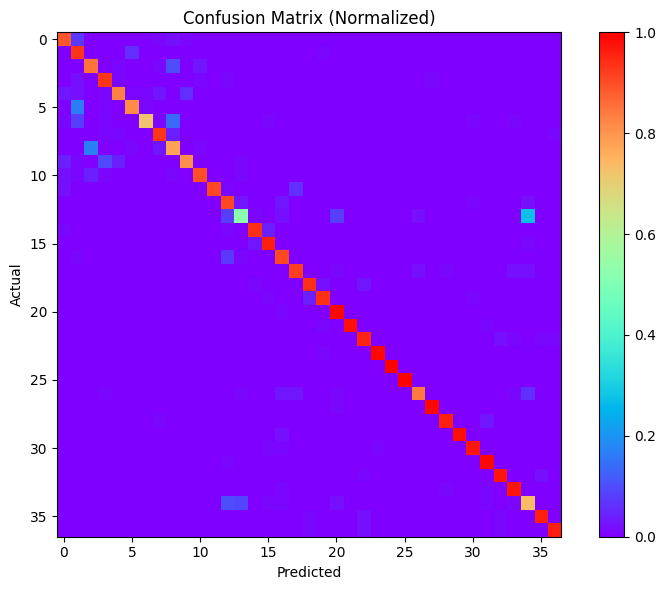

In [ ]:
draw_conf_mtrx(model, test_loader,path="conf_mtrx_cat_vs_dog.pdf")

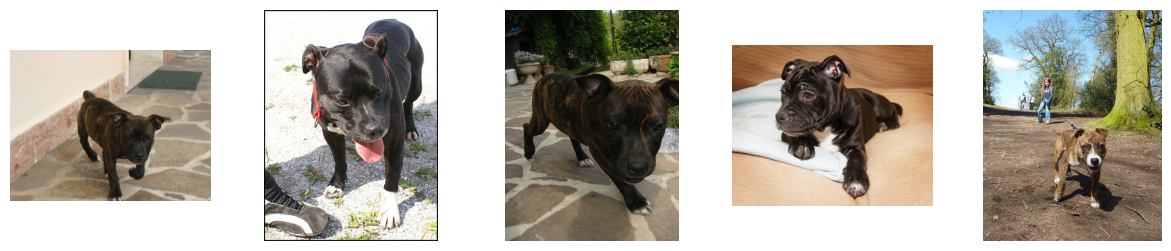

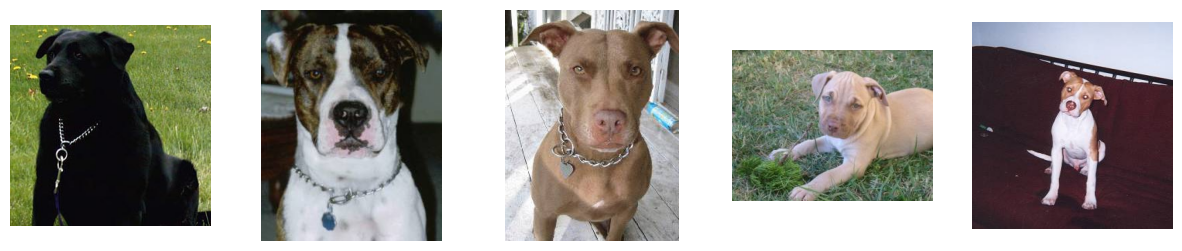

In [ ]:
show_class_img(34, test_ds, 5, path="staffordshire_bull_terrier(34).pdf")
show_class_img(13, test_ds, 5, path="american_pit_bull_terrier(13).pdf")

In [ ]:
train_loader_flower = DataLoader(train_ds_flower, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
val_loader_flower   = DataLoader(val_ds_flower,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader_flower  = DataLoader(test_ds_flower,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
model.train_loader = train_loader_flower
model.val_loader = val_loader_flower
model.test_loader = test_loader_flower

In [ ]:
# Test before startegy 1
model.test_model()

Test Accuracy: 1.85%


1.8479033404406537

In [ ]:
results = [] #90.48787135459253 1.8479033404406537
# Strategy 1: high lr in the beginnng
# Train agressively
model.optimizer = optim.AdamW([
    {'params': head_p, 'lr':1e-1, 'weight_decay':wd},
    {'params': back_p, 'lr':1e-2, 'weight_decay':wd},
])
model.scheduler = None
results.append(model.train_catastrophic(epochs=4, test_loader=test_loader, tee=True))
# Train less agrssively
model.optimizer = optim.AdamW([
    {'params': head_p, 'lr':1e-3, 'weight_decay':wd},
    {'params': back_p, 'lr':1e-4, 'weight_decay':wd},
])
model.scheduler = optim.lr_scheduler.StepLR(
        model.optimizer,
        step_size=5,
        gamma=0.1
    )
results.append(model.train_catastrophic(epochs=10, test_loader=test_loader, tee=True))


/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Epoch  1 | Train: 9.19% | Val: 8.11%
Test Accuracy: 8.03%
Test Accuracy: 2.70%
Epoch  2 | Train: 32.97% | Val: 30.81%
Test Accuracy: 30.06%
Test Accuracy: 2.89%
Epoch  3 | Train: 51.62% | Val: 67.03%
Test Accuracy: 63.47%
Test Accuracy: 3.38%
Epoch  4 | Train: 71.08% | Val: 70.27%
Test Accuracy: 67.73%
Test Accuracy: 3.22%
Epoch  1 | Train: 80.81% | Val: 74.32%
Test Accuracy: 72.14%
Test Accuracy: 3.16%
Epoch  2 | Train: 90.27% | Val: 78.38%
Test Accuracy: 76.55%
Test Accuracy: 3.00%
Epoch  3 | Train: 87.57% | Val: 78.92%
Test Accuracy: 78.32%
Test Accuracy: 3.19%
Epoch  4 | Train: 93.24% | Val: 79.73%
Test Accuracy: 79.53%
Test Accuracy: 3.27%
Epoch  5 | Train: 92.16% | Val: 81.08%
Test Accuracy: 80.74%
Test Accuracy: 3.43%
Epoch  6 | Train: 91.35% | Val: 80.81%
Test Accuracy: 80.17%
Test Accuracy: 3.60%
Epoch  7 | Train: 92.97% | Val: 80.81%
Test Accuracy: 80.74%
Test Accuracy: 3.54%
Epoch  8 | Train: 91.62% | Val: 82.16%
Test Accuracy: 81.31%
Test Accuracy: 3.43%
Epoch  9 | Train: 9

In [ ]:
results[0]["primary"].insert(0, 1.8479033404406537)
results[0]["secondary"].insert(0, 90.48787135459253)

In [ ]:
# Unify results from all epochs
results_all_epochs = {}
results_all_epochs["primary"] = results[0]["primary"] + results[1]["primary"]
results_all_epochs["secondary"] = results[0]["secondary"] + results[1]["secondary"]

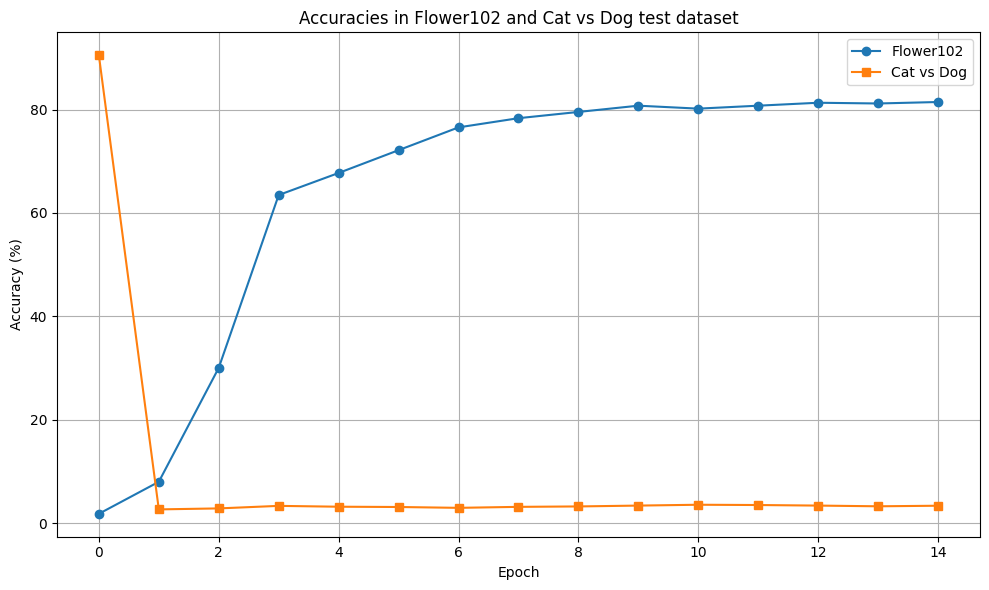

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class german_shorthaired(20) - Correct Predictions: 0
Class japanese_chin(23) - Correct Predictions: 0
Class havanese(22) - Correct Predictions: 0
Class great_pyrenees(21) - Correct Predictions: 0
Class boxer(16) - Correct Predictions: 0


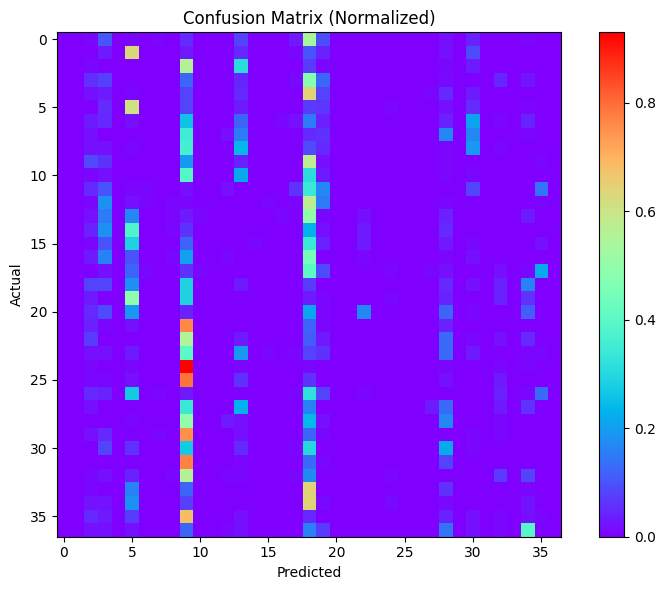

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class miniature_pinscher(26) - Correct Predictions: 0
Class Birman(2) - Correct Predictions: 5
Class samoyed(31) - Correct Predictions: 7
Class german_shorthaired(20) - Correct Predictions: 11
Class leonberger(25) - Correct Predictions: 12


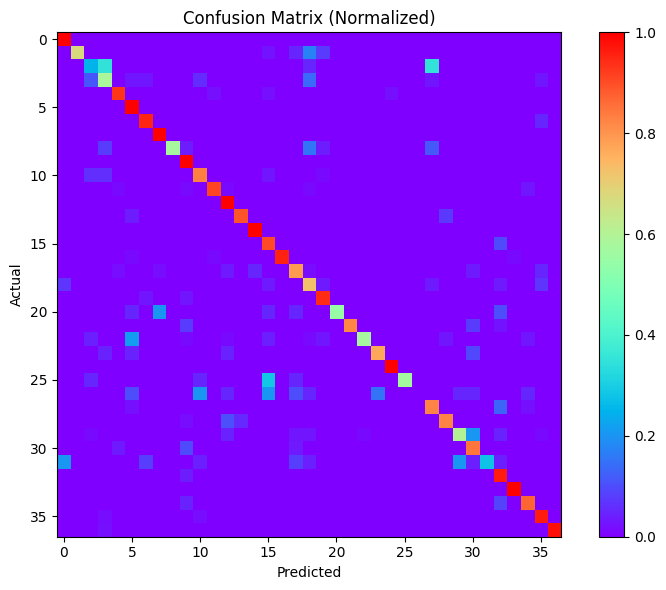

In [ ]:
plot_acc(results_all_epochs, "FlowerVsCathighLR")
draw_conf_mtrx(model, test_loader,path="conf_mtrx_cat_vs_dog_after_catastrophic_high.pdf")
draw_conf_mtrx(model, test_loader_flower,path="conf_mtrx_flowers_after_catastrophic_high.pdf")


In [ ]:
# Test before strategy 2
model.test_model()

Test Accuracy: 1.71%


1.7057569296375266

In [ ]:
# Note: you have to retrain the model on the cat vs dog dataset above
results2 = [] # 90.78768056691196 1.7057569296375266
# Strategy 2: low lr the whole time
# Train less agressively
model.optimizer = optim.AdamW([
    {'params': head_p, 'lr':1e-2, 'weight_decay':wd},
    {'params': back_p, 'lr':1e-3, 'weight_decay':wd},
])
model.scheduler = optim.lr_scheduler.StepLR(
        model.optimizer,
        step_size=2,
        gamma=0.1
    )
aug_tf = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(), transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225]),
])
# train_ds.dataset.transform = aug_tf
results2.append(model.train_catastrophic(epochs=20, test_loader=test_loader, tee=True))

Epoch  1 | Train: 41.35% | Val: 73.24%
Test Accuracy: 70.36%
Test Accuracy: 23.11%
Epoch  2 | Train: 88.38% | Val: 79.46%
Test Accuracy: 83.30%
Test Accuracy: 18.40%
Epoch  3 | Train: 95.14% | Val: 83.51%
Test Accuracy: 86.07%
Test Accuracy: 19.90%
Epoch  4 | Train: 99.19% | Val: 87.84%
Test Accuracy: 88.70%
Test Accuracy: 19.73%
Epoch  5 | Train: 100.00% | Val: 88.11%
Test Accuracy: 89.05%
Test Accuracy: 19.92%
Epoch  6 | Train: 99.73% | Val: 87.84%
Test Accuracy: 88.70%
Test Accuracy: 19.79%
Epoch  7 | Train: 100.00% | Val: 87.30%
Test Accuracy: 88.70%
Test Accuracy: 19.68%
Epoch  8 | Train: 99.73% | Val: 87.57%
Test Accuracy: 88.70%
Test Accuracy: 19.46%
Epoch  9 | Train: 100.00% | Val: 87.57%
Test Accuracy: 89.05%
Test Accuracy: 19.43%
Epoch 10 | Train: 100.00% | Val: 87.57%
Test Accuracy: 88.98%
Test Accuracy: 19.98%
Epoch 11 | Train: 99.73% | Val: 88.11%
Test Accuracy: 89.13%
Test Accuracy: 19.84%
Epoch 12 | Train: 99.19% | Val: 88.11%
Test Accuracy: 89.05%
Test Accuracy: 19.41%


In [ ]:
model.test_model(test_loader=test_loader_flower)

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Test Accuracy: 89.34%


89.33901918976545

In [ ]:
results2[0]["primary"].insert(0, 1.7057569296375266)
results2[0]["secondary"].insert(0, 90.78768056691196)

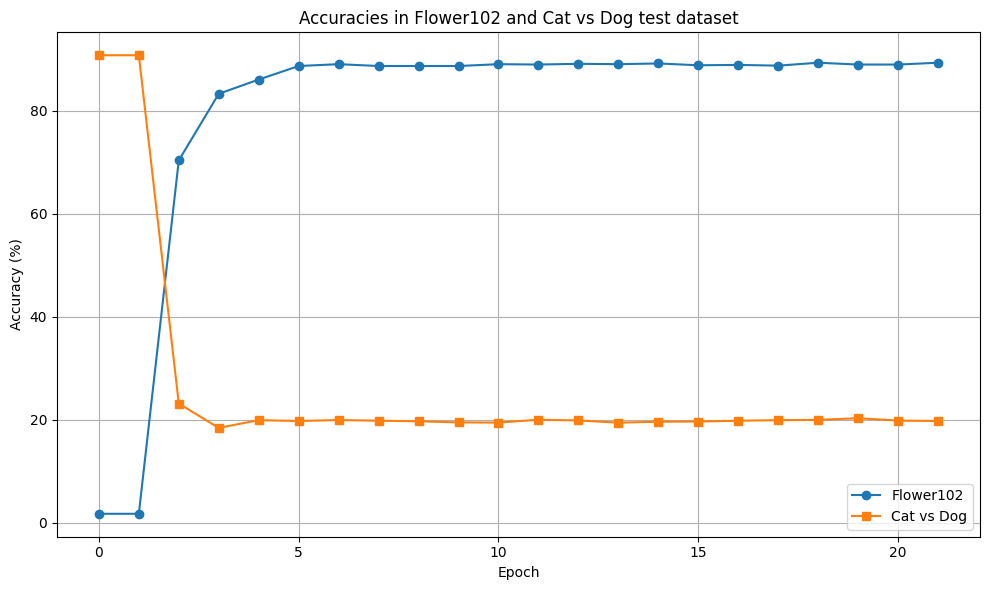

In [ ]:
plot_acc(results2[0], "FlowerVsCatmedLR")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class samoyed(31) - Correct Predictions: 0
Class Russian_Blue(9) - Correct Predictions: 0
Class Siamese(10) - Correct Predictions: 0
Class american_pit_bull_terrier(13) - Correct Predictions: 0
Class pomeranian(28) - Correct Predictions: 0


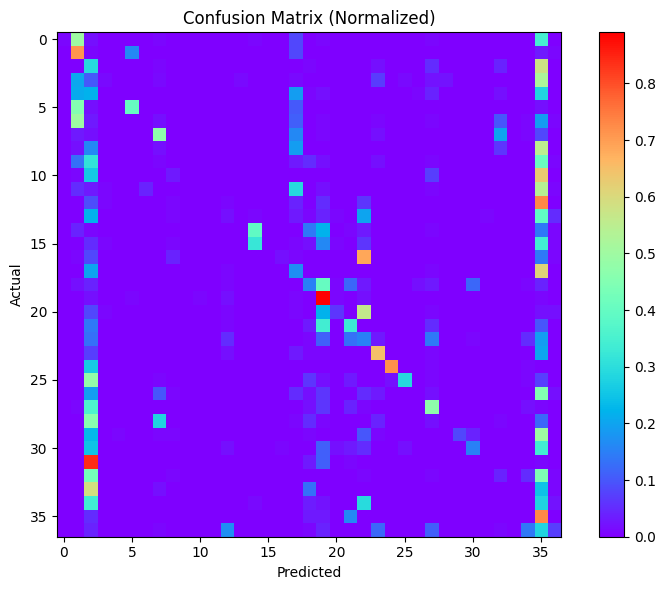

In [ ]:
draw_conf_mtrx(model, test_loader,path="conf_mtrx_cat_vs_dog_after_catastrophic_med.pdf")

/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py:624: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


Class Bombay(3) - Correct Predictions: 12
Class Birman(2) - Correct Predictions: 13
Class Abyssinian(0) - Correct Predictions: 16
Class beagle(15) - Correct Predictions: 16
Class german_shorthaired(20) - Correct Predictions: 17


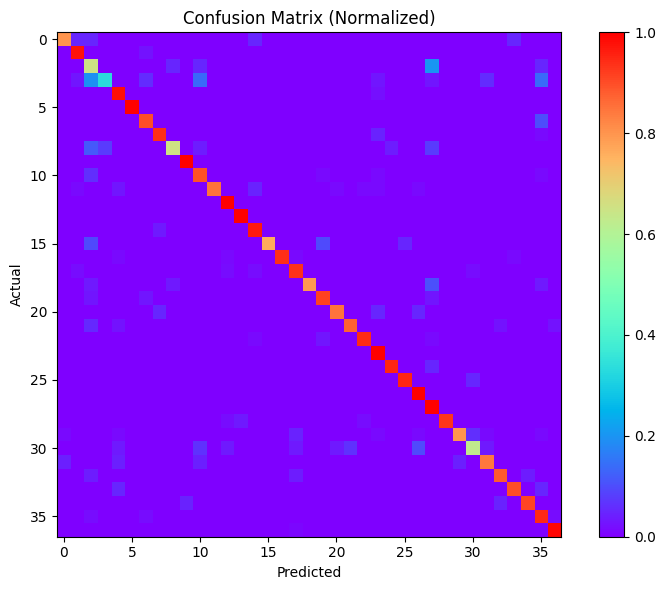

In [ ]:
draw_conf_mtrx(model, test_loader_flower,path="conf_mtrx_flowers_after_catastrophic_med.pdf")


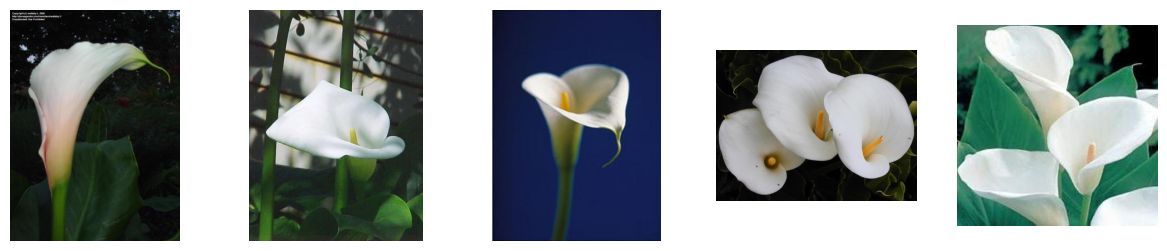

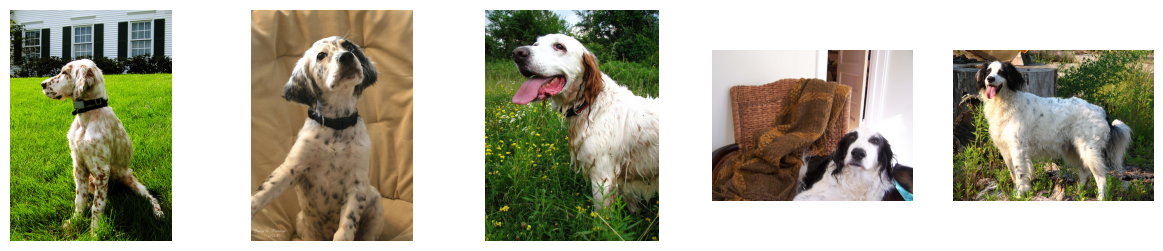

In [ ]:
test_ds_flowerrr = Flowers102Dataset("data", split='test', download=True)
show_class_img(19, test_ds_flowerrr, 5, path="flower_english_setter(19).pdf")
show_class_img(19, test_ds, 5, path="english_setter(19).pdf")


 ## CutMix

In [12]:
def rand_cutout(size, lam):
  H = size[2]
  W = size[3]

  ratio = np.sqrt(1 - lam)
  h = int(H * ratio)
  w = int(W * ratio)

  x = np.random.randint(W)
  y = np.random.randint(H)

  bx1 = np.clip(x - w // 2, 0, W)
  by1 = np.clip(y - h // 2, 0, H)
  bx2 = np.clip(x + w // 2, 0, W)
  by2 = np.clip(y + h // 2, 0, H)

  return bx1, bx2, by1, by2


In [21]:
def cutmix(imgs, labs, alpha):
  inds = torch.randperm(imgs.size(0))
  shuff_imgs = imgs[inds]
  shuff_labs = labs[inds]

  lam = np.random.beta(alpha, alpha)
  bounds = rand_cutout(imgs.size(), lam)
  imgs[:,:,bounds[0]:bounds[1], bounds[2]:bounds[3]] = shuff_imgs[:,:,bounds[0]:bounds[1], bounds[2]:bounds[3]]
  lam =  1 - ((bounds[0]-bounds[1])* (bounds[2]-bounds[3]) / (imgs.size(-1) * imgs.size(-2)))

  return imgs, labs, shuff_labs, lam

In [22]:
data = next(iter(train_loader))
print(data[0].size())
imgs, labs, shuff_labs, lam = cutmix(data[0],data[1], 1.5)

torch.Size([32, 3, 224, 224])


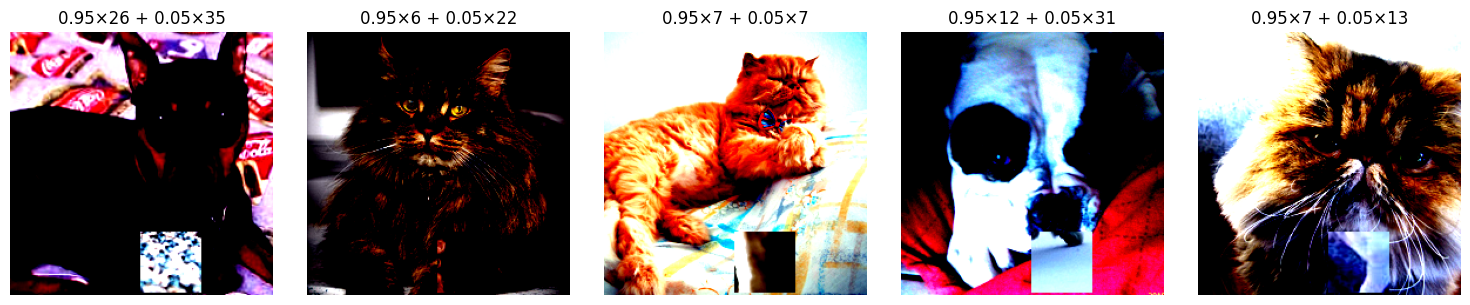

In [23]:
def cutmix_preview(loader, alpha=1.0, path="cutmix_preview.pdf"):
    imgs, labs = next(iter(loader))
    imgs_cutmix, labs, shuff_labs, lam = cutmix(imgs, labs, alpha)

    plt.figure(figsize=(15, 3))
    for i in range(5):
        img = imgs_cutmix[i].permute(1, 2, 0).clamp(0, 1)
        plt.subplot(1, 5, i + 1)
        plt.imshow(img)
        plt.axis('off')

        label_text = f"{lam:.2f}×{labs[i].item()} + {(1-lam):.2f}×{shuff_labs[i].item()}"
        plt.title(label_text)

    plt.tight_layout()
    plt.savefig(path)
    plt.show()


cutmix_preview(train_loader, alpha=0.5)




In [ ]:
for alpha in np.arange(0.1, 1, 0.1):
  print(f"alpha={alpha}")
  # Setup model
  use_aug = False
  freeze_bn    = True
  use_l2       = True
  sched    = 'steplr'
  fixed_rate = 2.0

  params = {'gradual_unfreezing': False, 'unfreezing_rate': fixed_rate, "cutmix":True, "alpha":alpha}
  model = NeuralNetwork(
      basemodel,
      len(breed_names),
      train_loader,
      val_loader,
      test_loader,
      unfreeze=6,
      parameters=params
  )
  model.model.to(device)

  # Setup best model
  print(f"\n>>> aug={use_aug}, freeze_bn={freeze_bn}, L2={use_l2}, sched={sched}")

  if freeze_bn:
      for m in model.model.modules():
          if isinstance(m, nn.BatchNorm2d):
              m.eval()
              for p in m.parameters():
                  p.requires_grad = False

  wd = 1e-2 if use_l2 else 0.0
  head_p = list(model.model.fc.parameters())
  back_p = [
      p for n,p in model.model.named_parameters()
      if p.requires_grad and not n.startswith("fc")
  ]
  model.optimizer = optim.AdamW([
      {'params': head_p, 'lr':1e-3, 'weight_decay':wd},
      {'params': back_p, 'lr':1e-4, 'weight_decay':wd},
  ])

  if sched == 'steplr':
      model.scheduler = optim.lr_scheduler.StepLR(
          model.optimizer,
          step_size=5,
          gamma=0.1
      )
  elif sched == 'onecycle':
      total_steps = len(train_loader) * 10
      model.scheduler = optim.lr_scheduler.OneCycleLR(
          model.optimizer,
          max_lr=[1e-3,1e-4],
          total_steps=total_steps,
          pct_start=0.3,
          anneal_strategy='cos'
      )
  else:
      model.scheduler = None

  model.train2(epochs=10)

# alpha = 0.5 best

alpha=0.1

>>> aug=False, freeze_bn=True, L2=True, sched=steplr
Epoch  1 | Train: 46.98% | Val: 91.03%
Epoch  2 | Train: 61.14% | Val: 92.66%
Epoch  3 | Train: 64.58% | Val: 90.76%
Epoch  4 | Train: 60.33% | Val: 91.30%
Epoch  5 | Train: 61.11% | Val: 91.58%
Epoch  6 | Train: 63.95% | Val: 92.39%
Epoch  7 | Train: 64.01% | Val: 92.12%
Epoch  8 | Train: 59.93% | Val: 92.93%
Epoch  9 | Train: 59.90% | Val: 93.21%
Epoch 10 | Train: 65.82% | Val: 92.12%
Test Accuracy: 88.53%
alpha=0.2

>>> aug=False, freeze_bn=True, L2=True, sched=steplr
Epoch  1 | Train: 49.61% | Val: 89.40%
Epoch  2 | Train: 54.29% | Val: 90.76%
Epoch  3 | Train: 61.84% | Val: 89.95%
Epoch  4 | Train: 62.23% | Val: 89.95%
Epoch  5 | Train: 60.81% | Val: 91.85%
Epoch  6 | Train: 69.29% | Val: 92.12%
Epoch  7 | Train: 68.54% | Val: 91.58%
Epoch  8 | Train: 65.76% | Val: 91.85%
Epoch  9 | Train: 62.53% | Val: 91.58%
Epoch 10 | Train: 65.40% | Val: 91.58%
Test Accuracy: 88.69%
alpha=0.30000000000000004

>>> aug=False, freeze

In [26]:
# Train with best alpha for longer
alpha=0.5
print(f"alpha={alpha}")
# Setup model
use_aug = False
freeze_bn    = True
use_l2       = True
sched    = 'steplr'
fixed_rate = 2.0

params = {'gradual_unfreezing': False, 'unfreezing_rate': fixed_rate, "cutmix":True, "alpha":alpha}
model = NeuralNetwork(
    basemodel,
    len(breed_names),
    train_loader,
    val_loader,
    test_loader,
    unfreeze=6,
    parameters=params
)
model.model.to(device)

# Setup best model
print(f"\n>>> aug={use_aug}, freeze_bn={freeze_bn}, L2={use_l2}, sched={sched}")

if freeze_bn:
    for m in model.model.modules():
        if isinstance(m, nn.BatchNorm2d):
            m.eval()
            for p in m.parameters():
                p.requires_grad = False

wd = 1e-2 if use_l2 else 0.0
head_p = list(model.model.fc.parameters())
back_p = [
    p for n,p in model.model.named_parameters()
    if p.requires_grad and not n.startswith("fc")
]
model.optimizer = optim.AdamW([
    {'params': head_p, 'lr':1e-2, 'weight_decay':wd},
    {'params': back_p, 'lr':1e-3, 'weight_decay':wd},
])

if sched == 'steplr':
    model.scheduler = optim.lr_scheduler.StepLR(
        model.optimizer,
        step_size=5,
        gamma=0.1
    )
elif sched == 'onecycle':
    total_steps = len(train_loader) * 10
    model.scheduler = optim.lr_scheduler.OneCycleLR(
        model.optimizer,
        max_lr=[1e-2,1e-3],
        total_steps=total_steps,
        pct_start=0.3,
        anneal_strategy='cos'
    )
else:
    model.scheduler = None

model.train2(epochs=20)

alpha=0.5

>>> aug=False, freeze_bn=True, L2=True, sched=steplr
Epoch  1 | Train: 36.93% | Val: 72.83%
Epoch  2 | Train: 49.82% | Val: 85.05%
Epoch  3 | Train: 50.66% | Val: 82.88%
Epoch  4 | Train: 54.68% | Val: 89.95%
Epoch  5 | Train: 54.44% | Val: 79.08%
Epoch  6 | Train: 61.50% | Val: 92.39%
Epoch  7 | Train: 74.55% | Val: 92.66%
Epoch  8 | Train: 68.00% | Val: 92.12%
Epoch  9 | Train: 69.60% | Val: 92.12%
Epoch 10 | Train: 70.98% | Val: 92.39%
Epoch 11 | Train: 64.34% | Val: 92.66%
Epoch 12 | Train: 66.43% | Val: 92.66%
Epoch 13 | Train: 67.78% | Val: 92.66%
Epoch 14 | Train: 71.89% | Val: 92.66%
Epoch 15 | Train: 69.66% | Val: 92.39%
Epoch 16 | Train: 65.46% | Val: 92.66%
Epoch 17 | Train: 66.82% | Val: 92.39%
Epoch 18 | Train: 72.77% | Val: 92.93%
Epoch 19 | Train: 68.33% | Val: 92.93%
Epoch 20 | Train: 66.12% | Val: 92.66%
Test Accuracy: 89.04%


89.04333605887163